In [1]:
import numpy as np
import scipy.sparse
import pandas as pd
pd.set_option("display.max_columns", None)
import time
import datetime
from sklearn import metrics
from scipy.sparse import coo_matrix, csc_matrix, csr_matrix
import tensorflow as tf
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
import tensorflow_transform as tft

from tqdm import tqdm
tqdm.pandas()

In [2]:
from google.cloud import bigquery
import gcsfs

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: res-nbcupea-dev-ds-sandbox-001


In [8]:
# Load the model
model_path = {}
model_path["concat_before"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23415/serving_model_dir"
model_path["concat_after"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Trainer/model/23407/serving_model_dir"

#model = tf.saved_model.load(model_path)

In [10]:
# Load the vocab
tags_list_dict = {}
tags_list_dict["concat_before"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23410/transform_fn/assets/tags"
tags_list_dict["concat_after"] = "gs://metadata-bucket-base/tfx-metadata-dev-pipeline-output/metadata_dev_edc_base_0_0_5/Transform/transform_graph/23398/transform_fn/assets/tags"
fs = gcsfs.GCSFileSystem(project="res-nbcupea-dev-ds-sandbox-001")
for key, path in tags_list_dict.items():
    if path == "": continue
    with fs.open(path, "r") as fid:
        tags_list = fid.read().split("\n")
    tags_list = [tag for tag in tags_list if tag != ""]
    tags_list_dict[key] = tags_list
tags_list

['Movie',
 'eng',
 'spa',
 'Drama',
 'Episode',
 'Action & Adventure',
 'Comedy',
 'Documentary',
 'Thriller',
 'Local',
 'Horror',
 'Romance',
 'Comedy drama',
 "Children's/Family Entertainment",
 'Crime drama',
 'Fantasy',
 'Animated',
 'Mystery',
 'Science fiction',
 'Sports',
 'Reality',
 'Western',
 'Entertainment',
 'Special',
 'Romance comedy',
 'Music',
 'Sports non-event',
 'Biography',
 'Independent',
 'Holiday',
 'Crime',
 'Military & War',
 'Religion',
 'older teens (ages 15+)',
 'Musical',
 'History drama',
 'Documentary drama',
 'History',
 'Shopping',
 'Educational',
 'kids (ages 5-9)',
 'teens (ages 13-14)',
 'Talk',
 'Travel',
 'Public Affairs',
 'Gay and Lesbian',
 'Foreign',
 'Food',
 'Animals',
 'Nature',
 'tweens (ages 10-12)',
 'News',
 'Miniseries',
 'Teens',
 'Martial arts',
 'Science & Technology',
 'Anime',
 'Courtroom',
 'Health',
 'Musical comedy',
 'Sitcom',
 'Outdoors',
 'Interview',
 'Variety',
 'Home & Garden',
 'Fashion',
 'Christmas',
 'Soccer',
 'Wedd

# Inspect training data only

In [6]:
query = """SELECT ROW_NUMBER() OVER() row_number, program_title, program_type, 
    program_longsynopsis AS synopsis, keywords AS tokens, tags
FROM `res-nbcupea-dev-ds-sandbox-001.metadata_enhancement.synopsis_dylan_150tag_with_tokens_and_keywords`
"""

df_train = client.query(query).to_dataframe()
df_train

,row_number,program_title,program_type,synopsis,tokens,tags
0,5169,Lena Lorenz: Regreso a la vida,Movie,Lena se encuentra ante un difícil dilema: tien...,"[Emotional, Berlin, Woman, Relationship, Uplif...","[Drama, Movie, spa]"
1,5170,Canada Crew,Episode,Bebe and Mo climb a tree to go bird watching a...,"[Animated, Kids, Children's/Family Entertainme...","[Action & Adventure, Animated, Episode, eng, E..."
2,5171,Quemar después de leer,Movie,Ozzie Cox es un agente de la CIA que escribe s...,"[Quest, Comedy-Drama, Gym, Car, Thriller, 2000...","[Comedy drama, Movie, Thriller, spa]"
3,5172,When Angels Come to Town,Movie,Un ángel navideño ve su trabajo en peligro cua...,"[Christmas, Drama, Holiday]","[Holiday, spa, Movie, Drama]"
4,5173,Escribir Amor En Sus Brazos,Movie,"Renee Yohe, una mujer de Florida comienza un v...","[Drug addict, 2010s, Docudrama, Florida, Dishe...","[Documentary drama, spa, Movie]"
...,...,...,...,...,...,...
514338,123441,Emmet Otter's Jug-Band Christmas,Movie,"Emmet Otter and his mother, Ma Otter, are dirt...","[Musical, Christmas, little kids (ages 5-7), D...","[Musical, Movie, kids (ages 5-9), Drama, eng, ..."
514339,123442,A Fairytale Christmas,Movie,The unexpected arrival of a longtime suitor co...,"[Local, Children's/Family Entertainment, Chris...","[Romance, Holiday, Christmas, eng, Movie, Chil..."
514340,123443,Passing Strange The Movie,Movie,"In 1970s Los Angeles, a rebellious middle-clas...","[Europe, Choir director, Teenager, Amsterdam, ...","[Documentary, Movie, Musical, Music, eng]"
514341,123444,The Kid,Movie,Una madre abandona a su hijo con una nota en u...,"[On the run, Comedy, Uncle, Cartoon & Animatio...","[Movie, Comedy drama, spa]"


In [7]:
# translate tags back into multi-hot labels
def tags_to_index(tags, tags_list):
    col = np.array([tags_list.index(t) for t in tags], dtype=int)
    data = np.ones(len(col), dtype=int)
    row = np.zeros(len(col), dtype=int)
    return coo_matrix((data, (row, col)), shape=(1, len(tags_list))).A[0]

df_train["labels"] = df_train["tags"].progress_apply(lambda x: tags_to_index(x, tags_list))
df_train

100%|██████████| 514343/514343 [00:31<00:00, 16186.78it/s]


,row_number,program_title,program_type,synopsis,tokens,tags,labels
0,5169,Lena Lorenz: Regreso a la vida,Movie,Lena se encuentra ante un difícil dilema: tien...,"[Emotional, Berlin, Woman, Relationship, Uplif...","[Drama, Movie, spa]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,5170,Canada Crew,Episode,Bebe and Mo climb a tree to go bird watching a...,"[Animated, Kids, Children's/Family Entertainme...","[Action & Adventure, Animated, Episode, eng, E...","[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,5171,Quemar después de leer,Movie,Ozzie Cox es un agente de la CIA que escribe s...,"[Quest, Comedy-Drama, Gym, Car, Thriller, 2000...","[Comedy drama, Movie, Thriller, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ..."
3,5172,When Angels Come to Town,Movie,Un ángel navideño ve su trabajo en peligro cua...,"[Christmas, Drama, Holiday]","[Holiday, spa, Movie, Drama]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5173,Escribir Amor En Sus Brazos,Movie,"Renee Yohe, una mujer de Florida comienza un v...","[Drug addict, 2010s, Docudrama, Florida, Dishe...","[Documentary drama, spa, Movie]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
514338,123441,Emmet Otter's Jug-Band Christmas,Movie,"Emmet Otter and his mother, Ma Otter, are dirt...","[Musical, Christmas, little kids (ages 5-7), D...","[Musical, Movie, kids (ages 5-9), Drama, eng, ...","[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
514339,123442,A Fairytale Christmas,Movie,The unexpected arrival of a longtime suitor co...,"[Local, Children's/Family Entertainment, Chris...","[Romance, Holiday, Christmas, eng, Movie, Chil...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
514340,123443,Passing Strange The Movie,Movie,"In 1970s Los Angeles, a rebellious middle-clas...","[Europe, Choir director, Teenager, Amsterdam, ...","[Documentary, Movie, Musical, Music, eng]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
514341,123444,The Kid,Movie,Una madre abandona a su hijo con una nota en u...,"[On the run, Comedy, Uncle, Cartoon & Animatio...","[Movie, Comedy drama, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [12]:
# Make predictions
input_data = {"synopsis": df_train['synopsis'].values[:, None], 
  "tokens": tf.ragged.constant(df_train["tokens"].values).to_sparse(),
 #"kewords": tf.ragged.constant(unscored_titles["keywords"].values).to_sparse(),
 }
dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(50)

# Looping over the models
for key, path in model_path.items():
    print(f"Loading model: {key}")
    
    model = tf.saved_model.load(path)
    res = []
    for batch in tqdm(dataset):
        transformed_features = model.tft_layer(batch)
        transformed_features["synopsis"] = transformed_features["synopsis"][:, None]
        y = model(transformed_features)
        res.append(y)
        
    res = list(tf.concat(res, axis=0).numpy())
    df_train[f"{key}_predicted"] = res
    # Temporarily save the results
    df_train.to_pickle("./explore_emd_04_train_predicted_values.pkl", compression="gzip")

df_train


Loading model: concat_before


  0%|          | 0/10287 [00:00<?, ?it/s]

100%|██████████| 10287/10287 [36:08<00:00,  4.74it/s]


Loading model: concat_after


  0%|          | 0/10287 [00:00<?, ?it/s]

100%|██████████| 10287/10287 [36:02<00:00,  4.76it/s]


,row_number,program_title,program_type,synopsis,tokens,tags,labels,concat_before_predicted,concat_after_predicted
0,5169,Lena Lorenz: Regreso a la vida,Movie,Lena se encuentra ante un difícil dilema: tien...,"[Emotional, Berlin, Woman, Relationship, Uplif...","[Drama, Movie, spa]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8415508, 0.14370725, 0.9622393, 0.63950944,...","[0.7675041, 0.09854674, 0.96487135, 0.55753905..."
1,5170,Canada Crew,Episode,Bebe and Mo climb a tree to go bird watching a...,"[Animated, Kids, Children's/Family Entertainme...","[Action & Adventure, Animated, Episode, eng, E...","[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.080235906, 0.97324526, 0.41331726, 0.318584...","[0.08906501, 0.97745824, 0.40012932, 0.4089919..."
2,5171,Quemar después de leer,Movie,Ozzie Cox es un agente de la CIA que escribe s...,"[Quest, Comedy-Drama, Gym, Car, Thriller, 2000...","[Comedy drama, Movie, Thriller, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0.86451423, 0.1437781, 0.95855224, 0.36282367...","[0.78887063, 0.09489721, 0.96932393, 0.4837678..."
3,5172,When Angels Come to Town,Movie,Un ángel navideño ve su trabajo en peligro cua...,"[Christmas, Drama, Holiday]","[Holiday, spa, Movie, Drama]","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8809329, 0.16313666, 0.9014823, 0.76027745,...","[0.86124116, 0.11891149, 0.898483, 0.54876065,..."
4,5173,Escribir Amor En Sus Brazos,Movie,"Renee Yohe, una mujer de Florida comienza un v...","[Drug addict, 2010s, Docudrama, Florida, Dishe...","[Documentary drama, spa, Movie]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.83402526, 0.108395375, 0.95319396, 0.513728...","[0.74231434, 0.084736824, 0.9523972, 0.5224733..."
...,...,...,...,...,...,...,...,...,...
514338,123441,Emmet Otter's Jug-Band Christmas,Movie,"Emmet Otter and his mother, Ma Otter, are dirt...","[Musical, Christmas, little kids (ages 5-7), D...","[Musical, Movie, kids (ages 5-9), Drama, eng, ...","[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.86665046, 0.9744004, 0.120240524, 0.5985051...","[0.8226791, 0.9722253, 0.11132396, 0.5074819, ..."
514339,123442,A Fairytale Christmas,Movie,The unexpected arrival of a longtime suitor co...,"[Local, Children's/Family Entertainment, Chris...","[Romance, Holiday, Christmas, eng, Movie, Chil...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0.7487434, 0.9527067, 0.08895473, 0.45858213,...","[0.8467068, 0.94265676, 0.07908636, 0.622632, ..."
514340,123443,Passing Strange The Movie,Movie,"In 1970s Los Angeles, a rebellious middle-clas...","[Europe, Choir director, Teenager, Amsterdam, ...","[Documentary, Movie, Musical, Music, eng]","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.8016001, 0.96291417, 0.18151367, 0.62925, 0...","[0.7939563, 0.96235996, 0.15207995, 0.61611027..."
514341,123444,The Kid,Movie,Una madre abandona a su hijo con una nota en u...,"[On the run, Comedy, Uncle, Cartoon & Animatio...","[Movie, Comedy drama, spa]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.8105486, 0.13934676, 0.96825135, 0.47430128...","[0.7816994, 0.1079385, 0.9718759, 0.53463185, ..."


In [14]:
## Binary classifier precision and recall ROC
classifier_metrics = {"pr_auc": [], "roc_auc":[], "accuracy":[]}
classifier_metrics = {k: classifier_metrics.copy() for k in model_path.keys()}
labels = np.stack(df_train["labels"]).astype(int)

# Looping over model
for key in classifier_metrics:
    predicted_score = np.stack(df_train[f"{key}_predicted"])
    predicted_binary = (predicted_score > 0.5).astype(int)
    # Looping over tags / vector
    for t in tqdm(range(labels.shape[1])):
        if np.all(labels[:, t] < 1E-3):
            accuracy, pr_auc, roc_auc = -1, -1, -1
        elif  np.all(labels[:, t]==1):
            accuracy, pr_auc, roc_auc = 10, 10, 10
        else:
            accuracy = (predicted_binary[:, t] == labels[:, t]).mean()
            pr_auc = metrics.average_precision_score(labels[:, t], predicted_score[:, t])
            roc_auc = metrics.roc_auc_score(labels[:, t], predicted_score[:, t])

        classifier_metrics[key]["accuracy"].append(accuracy)
        classifier_metrics[key]["pr_auc"].append(pr_auc)
        classifier_metrics[key]["roc_auc"].append(roc_auc)
    classifier_metrics[key]["percent_pos_labels"] = labels.mean(axis=0)



100%|██████████| 146/146 [00:46<00:00,  3.16it/s]


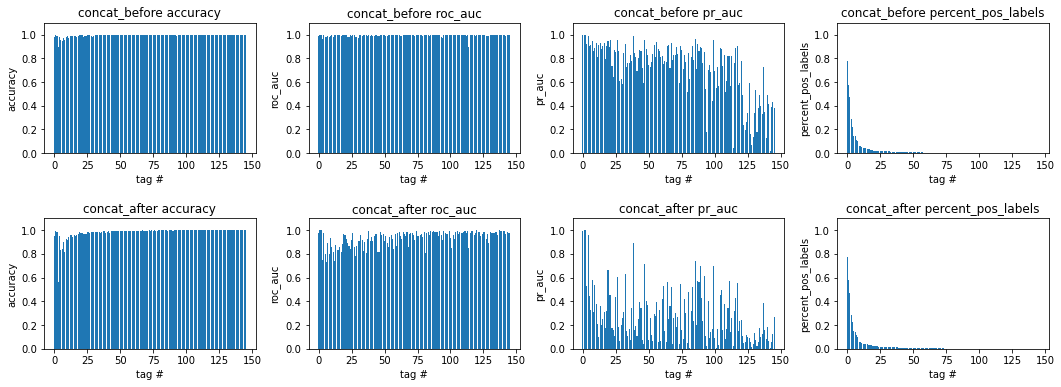

In [17]:
# Plot out the performance of classifier
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 4, figsize=(18, 6))

classifier_metrics[key]["percent_pos_labels"] = labels.mean(axis=0)

for j, key in enumerate(classifier_metrics.keys()):
    for i, m in enumerate(["accuracy", "roc_auc", "pr_auc", "percent_pos_labels"]):
        ax = axs[j, i]
        ax.bar(np.arange(len(classifier_metrics[key][m])), classifier_metrics[key][m])
        ax.set_title(f"{key} {m}")
        ax.set_xlabel("tag #")
        ax.set_ylabel(m)
        ax.set_ylim(0, 1.1)
        
fig.subplots_adjust(wspace=0.25, hspace=0.5)


# Evaluation on the content-to-content recommendations

In [16]:
TITLES_QUERY = """
    WITH titles_data AS (SELECT 
        TitleDetails_title, 
        TitleType,
        STRING_AGG(DISTINCT TitleDetails_longsynopsis, ' ') AS TitleDetails_longsynopsis,
        SPLIT(STRING_AGG(DISTINCT TitleDetails_longsynopsis, ' '), " ") AS synopsis_list, 
        cid.content_ordinal_id,
    FROM `res-nbcupea-dev-ds-sandbox-001.metadata_enhancement.ContentMetadataView` cmv
    LEFT JOIN `res-nbcupea-dev-ds-sandbox-001.recsystem.ContentOrdinalId` cid
        ON LOWER(cmv.TitleDetails_title) = LOWER(cid.program_title)
    WHERE 
        TitleDetails_longsynopsis IS NOT NULL
        AND cid.content_ordinal_id IS NOT NULL
    GROUP BY 
        TitleDetails_title, 
        TitleType, 
        cid.content_ordinal_id),
    
    raw_tags AS (
        SELECT TitleDetails_title, ss AS tokens
        FROM titles_data,
        UNNEST(synopsis_list) ss WITH OFFSET index
        WHERE index BETWEEN 1 AND 256
    ),
        
    tags_data AS (
        SELECT a.TitleDetails_title, ARRAY_AGG(DISTINCT a.tokens) AS tokens
        FROM raw_tags a
        INNER JOIN `res-nbcupea-dev-ds-sandbox-001.metadata_enhancement.node2vec_token_edc_dev` tk
        ON tk.tokens=a.tokens
        GROUP BY a.TitleDetails_title
    ),
    
    unfiltered AS (SELECT a.TitleDetails_title, a.TitleType, a.TitleDetails_longsynopsis,
        a.content_ordinal_id, 
        CASE
            WHEN ARRAY_LENGTH(b.tokens) < 1 OR ARRAY_LENGTH(b.tokens) IS NULL THEN ["TV"]
            ELSE b.tokens
        END AS tokens,
    FROM titles_data a
    LEFT JOIN tags_data b
    ON LOWER(a.TitleDetails_title)=LOWER(b.TitleDetails_title)
    )
    SELECT TitleDetails_title AS title, TitleType, TitleDetails_longsynopsis, content_ordinal_id, 
        ARRAY_AGG(DISTINCT tk) AS tokens
    FROM unfiltered,
    UNNEST(tokens) tk WITH OFFSET index
    WHERE index BETWEEN 1 AND 64
    GROUP BY TitleDetails_title, TitleType, TitleDetails_longsynopsis, content_ordinal_id
"""
df_titles = client.query(TITLES_QUERY) \
                        .to_dataframe() \
                        .drop_duplicates(subset=['title']) \
                        .reset_index(drop=True)
    
df_titles

,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,tokens
0,Man on the Moon,Movie,Milos Forman's film spotlights Andy Kaufman's ...,538,"[spotlights, sitcom, performance, wrestling, b..."
1,Age of Dinosaurs,Movie,A former firefighter fights to rescue his teen...,52,"[escape, museum, dinosaurs, firefighter, rescu..."
2,The Big Lebowski,Movie,"Bowling buddies (Jeff Bridges, John Goodman) b...",1153,"[become, buddies, multimillionaire, 1990s, wan..."
3,Peter Pan,Movie,Peter Pan (Jeremy Sumpter) leads Wendy (Rachel...,1955,"[involving, band, leads, brothers, Captain, ad..."
4,The Phantom of the Opera,Movie,An acid-scarred composer (Claude Rains) rises ...,909,"[dwarf, sewer, London, composer, opera, helper..."
...,...,...,...,...,...
2251,Muddy Waters and the Rolling Stones: Live at t...,Programme,"This November 22, 1981, concert at Chicago's C...",2093,"[Lounge, features]"
2252,Reagan Jeans,Programme,Will shrink by 5 percent.,1424,[shrink]
2253,Thank You Notes: Apple Watch & more,Programme,"Jimmy pens thank you notes to smirks, Presiden...",1344,"[President, memoir]"
2254,Turlington's Lower Back Tattoo Remover,Programme,Erase regrets in an easy application. Erase re...,1347,[regrets]


In [17]:
input_data = {"synopsis": df_titles['TitleDetails_longsynopsis'].values[:, None], 
  "tokens": tf.ragged.constant(df_titles["tokens"].values).to_sparse(),
 #"kewords": tf.ragged.constant(unscored_titles["keywords"].values).to_sparse(),
 }
dataset = tf.data.Dataset.from_tensor_slices(input_data).batch(50)

# Looping over the models
for key, path in model_path.items():
    print(f"Loading model: {key}")
   
    model = tf.saved_model.load(path)
    res = []
    for batch in tqdm(dataset):
        transformed_features = model.tft_layer(batch)
        transformed_features["synopsis"] = transformed_features["synopsis"][:, None]
        y = model(transformed_features)
        res.append(y)
        
    res = list(tf.concat(res, axis=0).numpy())
    df_titles[f"{key}_predicted"] = res
    # Temporarily save the results
    df_titles.to_pickle("./explore_emd_06_titles_predicted_values.pkl", compression="gzip")

df_titles


Loading model: concat_before


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [06:34<00:00,  8.58s/it]


Loading model: concat_after


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [06:42<00:00,  8.75s/it]


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,tokens,concat_before_predicted,concat_after_predicted
0,Man on the Moon,Movie,Milos Forman's film spotlights Andy Kaufman's ...,538,"[spotlights, sitcom, performance, wrestling, b...","[0.7893785, 0.93872786, 0.112142384, 0.4544167...","[0.81903255, 0.9575243, 0.109604955, 0.3816336..."
1,Age of Dinosaurs,Movie,A former firefighter fights to rescue his teen...,52,"[escape, museum, dinosaurs, firefighter, rescu...","[0.77314806, 0.9849237, 0.09760952, 0.49885008...","[0.7631109, 0.9889021, 0.089025766, 0.47808453..."
2,The Big Lebowski,Movie,"Bowling buddies (Jeff Bridges, John Goodman) b...",1153,"[become, buddies, multimillionaire, 1990s, wan...","[0.83912647, 0.9796145, 0.06587809, 0.5415562,...","[0.8452988, 0.985549, 0.054160565, 0.49293938,..."
3,Peter Pan,Movie,Peter Pan (Jeremy Sumpter) leads Wendy (Rachel...,1955,"[involving, band, leads, brothers, Captain, ad...","[0.7790166, 0.96157825, 0.107638955, 0.4530050...","[0.82701194, 0.9631461, 0.10829201, 0.42078775..."
4,The Phantom of the Opera,Movie,An acid-scarred composer (Claude Rains) rises ...,909,"[dwarf, sewer, London, composer, opera, helper...","[0.7128815, 0.94149184, 0.09629494, 0.46978706...","[0.7545299, 0.9483763, 0.08617556, 0.41906956,..."
...,...,...,...,...,...,...,...
2251,Muddy Waters and the Rolling Stones: Live at t...,Programme,"This November 22, 1981, concert at Chicago's C...",2093,"[Lounge, features]","[0.544415, 0.9857986, 0.06807554, 0.30387327, ...","[0.5764122, 0.9864591, 0.052640945, 0.21805325..."
2252,Reagan Jeans,Programme,Will shrink by 5 percent.,1424,[shrink],"[0.46873817, 0.94513273, 0.1337001, 0.46820515...","[0.52562815, 0.95571566, 0.04808095, 0.4125509..."
2253,Thank You Notes: Apple Watch & more,Programme,"Jimmy pens thank you notes to smirks, Presiden...",1344,"[President, memoir]","[0.42271426, 0.9588735, 0.07696861, 0.32815617...","[0.3129933, 0.972355, 0.08221942, 0.2793237, 0..."
2254,Turlington's Lower Back Tattoo Remover,Programme,Erase regrets in an easy application. Erase re...,1347,[regrets],"[0.7816825, 0.8368404, 0.16064063, 0.50453687,...","[0.6959361, 0.8664497, 0.14164117, 0.5034233, ..."


In [14]:
df_titles["concat_before_predicted"][0].shape

(146,)

In [8]:
df_titles = pd.read_pickle("./explore_emd_06_titles_predicted_values.pkl", compression="gzip")
df_titles

,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,tokens,concat_before_predicted,concat_after_predicted
0,Magnificent Obsession,Movie,1244,A guilt-stricken playboy (Rock Hudson) becomes...,"[Heartwarming, Accidental death, Love, Resusci...","[0.9418787, 0.9257921, 0.1535384, 0.77713126, ...","[0.919917, 0.91761744, 0.103873976, 0.6606469,..."
1,Gilbert,Movie,386,Comedian Gilbert Gottfried recounts his career...,"[Documentary, Comedy, Movies, Independent]","[0.9251238, 0.96280277, 0.08226197, 0.37148157...","[0.8185581, 0.96545726, 0.0461627, 0.5347202, ..."
2,A Christmas Princess,Movie,1669,A prince from a small European country arrives...,"[Romantic comedy, Comedy, Holiday, Romance, Dr...","[0.8365671, 0.9431505, 0.09008518, 0.5619604, ...","[0.776748, 0.92949194, 0.07241741, 0.5250763, ..."
3,Johnny Carson,Programme,473,Actor Albert Brooks; actress Susan Sarandon. A...,"[TV, Comedy, Talk]","[0.06334085, 0.86650866, 0.4585355, 0.27513903...","[0.16512898, 0.88929284, 0.5864045, 0.34762278..."
4,Idlewild,Movie,453,"In a 1930s speakeasy, a piano player (André Be...","[1920s, Love, United States, Dense, Action & A...","[0.5486538, 0.9310931, 0.17647716, 0.63838905,...","[0.523386, 0.95097655, 0.18716654, 0.49275383,..."
...,...,...,...,...,...,...,...
1567,Jar Glove,Programme,1374,Only $19.99 - Order now on www.jarglove.com,"[Entertainment, TV]","[0.2773964, 0.91856503, 0.20170723, 0.3296297,...","[0.44729796, 0.9507281, 0.21297143, 0.35461298..."
1568,The Nerds - Broken Fridge,Programme,1405,The nerds get a peek of the repairman's busine...,"[TV, Entertainment]","[0.33148706, 0.9719739, 0.08691238, 0.5064453,...","[0.6651408, 0.97065496, 0.09133775, 0.47278184..."
1569,Wacky Glue,Programme,1410,It's wacky crazy glue.,"[Entertainment, TV]","[0.20701838, 0.79904926, 0.104136094, 0.386637...","[0.47952518, 0.7896056, 0.11278894, 0.45754683..."
1570,Action Cats,Programme,1317,Action Cat toys are plastic armor and weapons ...,"[TV, Entertainment]","[0.19697957, 0.924143, 0.15502992, 0.4081158, ...","[0.51657426, 0.9485987, 0.11853725, 0.30093756..."


In [13]:
# Do the pairwise similarity
def cosine_sim(P):
    P = P / np.sqrt(np.sum(P**2, axis=1, keepdims=True))
    cos_sim_c2c = P @ P.T
    cos_sim_c2c = np.nan_to_num(cos_sim_c2c, nan=-1)
    return cos_sim_c2c

def kl_divergence(P):
    P = P / np.sum(P, axis=1, keepdims=True)
    H_p = -np.sum(P * np.log(P), axis=1, keepdims=True)
    H_p_q = -(P @ np.log(P.T))
    D_kl = H_p_q - H_p
    return D_kl

def js_divergence(P):
    D_kl = kl_divergence(P)
    return D_kl * 0.5 + D_kl.T * 0.5

similarity = {"cosine":{}}

for s in similarity:
    for key in model_path.keys():
        predicted = np.stack(df_titles[f"{key}_predicted"].values)
        similarity[s][key] = cosine_sim(predicted)
        
        # Slice out top 15 recommendations
        score = list(np.sort(similarity[s][key], axis=1)[:, ::-1][:, 1:(15+1)])
        sim_c2c_argsort = np.argsort(similarity[s][key], axis=1)[:, ::-1][:, 1:]
        titles = list(np.take(df_titles["title"].values, sim_c2c_argsort[:, :15]))
        titles_type = list(np.take(df_titles["TitleType"].values, sim_c2c_argsort[:, :15]))
        synopsis = list(np.take(df_titles["TitleDetails_longsynopsis"].values, sim_c2c_argsort[:, :15]))
        content_id = list(np.take(df_titles["content_ordinal_id"].values, sim_c2c_argsort[:, :15]))
        dict_list = [{"title": tt, "TitleType": ttype, "TitleDetails_longsynopsis": syn, "content_ordinal_id": cid, "score": sc} \
                     for tt, ttype, syn, cid, sc in zip(titles, titles_type, synopsis, content_id, score)]

        df_titles[f"{s}_{key}_top15"] = dict_list
        # Calculate a type match
        df_titles[f"{s}_{key}_type_match"] = (np.stack(titles_type) == df_titles["TitleType"][:, None]).mean(axis=1)
        
df_titles

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,tokens,concat_after_predicted,cosine_concat_after_top15,cosine_concat_after_type_match
0,End of Days,Movie,321,An ex-cop (Arnold Schwarzenegger) must protect...,"[Apocalypse, Thriller, Horror, Satan, Action &...","[0.882541, 0.9316562, 0.094144076, 0.5678999, ...","{'title': ['The Raven', 'The Bourne Identity',...",1.000000
1,Leaving Normal,Movie,511,A cocktail waitress (Christine Lahti) and a ba...,"[Abused wife, Comedy-Drama, Quest, Alaska, Str...","[0.8342354, 0.966663, 0.094906956, 0.5004708, ...","{'title': ['Neighbors', 'Still Waiting ...', '...",1.000000
2,Won't You Be My Neighbor?,Movie,1185,Filmmaker Morgan Neville examines the life and...,"[Documentary, Great Boy Role Models, Biography...","[0.7459418, 0.922972, 0.089052916, 0.4305468, ...","{'title': ['I Know That Voice', 'Ultrasuede: I...",0.933333
3,Poker After Dark,Programme,641,Players compete for cash. Professional poker p...,"[Sports, Poker, Sports non-event, Card Games, ...","[0.091017544, 0.9669421, 0.466262, 0.3016851, ...","{'title': ['The National Dog Show', 'The Big B...",1.000000
4,House of the Dead,Movie,438,"Party-bound young people (Jonathan Cherry, Tyr...","[Girlfriend, Zombies, On the run, Horror, Base...","[0.8887112, 0.9192052, 0.087931514, 0.53736955...","{'title': ['You're Next', 'The Ticket', 'The B...",1.000000
...,...,...,...,...,...,...,...,...
2262,Miss Conception,Movie,1520,"Hearing her biological clock ticking away, a w...","[Amusing, London, Breakup, Apartment, Business...","[0.81293625, 0.88762593, 0.09214839, 0.6088209...","{'title': ['The Saver', 'Girl Most Likely', 'S...",1.000000
2263,Adam Driver End of Summer - Monologue,Programme,1318,"Host Adam Driver suffers through Aidy Bryant, ...","[TV, Entertainment]","[0.5015774, 0.9621866, 0.0949139, 0.45676357, ...","{'title': ['Amber Says What: Trump parade', 'J...",0.400000
2264,Crystal Gravy,Programme,1325,"A commercial for Crystal Gravy, a new clear gr...","[Entertainment, TV]","[0.5988498, 0.95629275, 0.17241862, 0.43801072...","{'title': ['Wade Blasingame', 'California Type...",0.533333
2265,Ron Swanson Loves Meat,Programme,1392,Ron Swanson (Nick Offerman) is a man of many m...,"[TV, Comedy]","[0.6837376, 0.9281856, 0.08775613, 0.39873037,...","{'title': ['Misery Loves Comedy', 'Al Madrigal...",0.400000


## Plotting out the distribution of cosine similarities

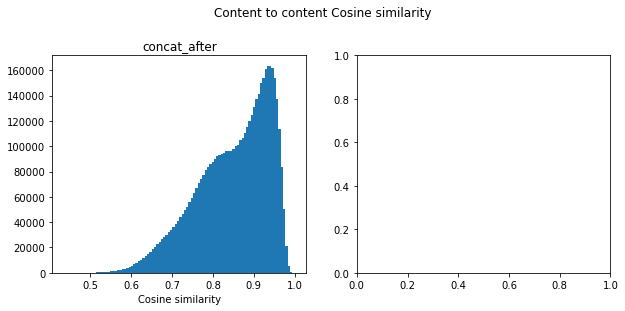

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for i, key in enumerate(model_path.keys()):
    ax = axs[i]
    ax.hist(np.sort(similarity["cosine"][key], axis=1)[:, ::-1][:, 1:].ravel(), bins=100) # remove cosine-sim with itself
    ax.set_xlabel("Cosine similarity")
    ax.set_title(key)
    
_ = fig.suptitle("Content to content Cosine similarity", y=1.05)

## Query some shows

In [23]:
# Do some quries
from IPython.display import display
def query_shows_c2c(df_titles, show_name, key="concat_after", sim_metric="cosine", show_res=True):
    pdf = df_titles.loc[df_titles["title"]==show_name, :]
    pdf_query = pdf[["content_ordinal_id", "title", "TitleType", "TitleDetails_longsynopsis"]]
    pdf_res = pd.DataFrame(pdf[f"{sim_metric}_{key}_top15"].values[0])
    if show_res:
        print("Query")
        display(pdf_query)
        print(f"Result: {sim_metric} {key}")
        display(pdf_res)
    
    return pdf_query, pdf_res
    

In [25]:
_ = query_shows_c2c(df_titles, "The Office", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1668,1891,The Office,Programme,An attractive woman's arrival has the male sta...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Cheers,Programme,Carla tricks a man into believing he is the fa...,228,0.986346
1,Father of the Pride,Programme,Larry the lion becomes the new star of the sho...,341,0.979514
2,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.977582
3,Intelligence,Programme,Coming Soon The team is forced to retake their...,1049,0.976424
4,The Office: Superfan Episodes,Programme,Michael returns from his Jamaican vacation; an...,1968,0.976253
5,Vanderpump Rules,Programme,Lisa has her staff help create a parade float ...,1315,0.975254
6,Kitchen Nightmares,Programme,"Chef Ramsay visits a chaotic Burbank, Calif., ...",490,0.972304
7,Two and a Half Men,Programme,Zoey and her daughter move in with Walden; Ala...,973,0.972219
8,Sunnyside,Programme,"Garrett and the gang race all over the city, d...",783,0.972086
9,30 Rock,Programme,Liz must find a way to occupy her time during ...,17,0.971188


In [17]:
_ = query_shows_c2c(df_titles, "30 Rock", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1559,17,30 Rock,Programme,Liz must find a way to occupy her time during ...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Two and a Half Men,Programme,Zoey and her daughter move in with Walden; Ala...,973,0.983837
1,WAGS LA,Programme,Nicole arranges a semi-nude photo shoot to tes...,992,0.981636
2,The Wrong Girl,Programme,Lily and Jack's relation is talked about. Lily...,951,0.981224
3,Zoey's Extraordinary Playlist,Programme,"Zoey, an introverted computer programmer livin...",1022,0.981182
4,Cheers,Programme,Carla tricks a man into believing he is the fa...,228,0.979801
5,WAGS: Miami,Programme,Darnell invites Hencha and Metisha to her brun...,993,0.979195
6,Total Bellas,Programme,"In the series premiere, Brie and Bryan move in...",2283,0.977212
7,Everybody Loves Raymond,Programme,Debra can't help but question the solidity of ...,330,0.976347
8,Curvy Girls,Programme,"Ivory, Lorna and Rosie compete for the same nu...",1756,0.976289
9,Modern Family,Programme,Claire and Phil each take on one of the kids' ...,2036,0.976152


In [18]:
_ = query_shows_c2c(df_titles, "Punky Brewster", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1662,656,Punky Brewster,Programme,Punky makes a date with two boys for the same ...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The PJs,Programme,Thurgood and Juicy compete for a Grill Master ...,2164,0.979358
1,Psych,Programme,Gus and Shawn spend a weekend searching for a ...,652,0.974345
2,Cheers,Programme,Carla tricks a man into believing he is the fa...,228,0.974212
3,Sunnyside,Programme,"Garrett and the gang race all over the city, d...",783,0.973939
4,Father of the Pride,Programme,Larry the lion becomes the new star of the sho...,341,0.973750
5,The Munsters,Programme,Lily and Herman take part-time jobs to buy eac...,902,0.973389
6,Leave It to Beaver,Programme,Beaver tries to amuse himself while Wally is a...,510,0.971656
7,The Jeff Foxworthy Show,Programme,Observations by the blue-collar owner (Jeff Fo...,874,0.971304
8,Kitchen Nightmares,Programme,"Chef Ramsay visits a chaotic Burbank, Calif., ...",490,0.970241
9,Keeping Up With the Kardashians,Programme,Kim poses for a Playboy photo shoot. A trip to...,1301,0.969493


In [19]:
_ = query_shows_c2c(df_titles, "Parks and Recreation", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1788,626,Parks and Recreation,Programme,"Leslie asks Ben, Andy and April to help host a..."


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Keeping Up With the Kardashians,Programme,Kim poses for a Playboy photo shoot. A trip to...,1301,0.985542
1,The Office: Superfan Episodes,Programme,Michael returns from his Jamaican vacation; an...,1968,0.984286
2,Mr. Robinson,Programme,After learning he and Jimmy may lose their job...,1978,0.981850
3,Indebted,Programme,Deb's big brother Art is coming to town; a tri...,460,0.980714
4,Chrisley Knows Best,Programme,Todd wants Chase and Savannah to learn the val...,236,0.980400
5,The Jeff Foxworthy Show,Programme,Observations by the blue-collar owner (Jeff Fo...,874,0.979561
6,Superstore,Programme,"Amy tries to make Mateo her new assistant, lea...",784,0.978185
7,Southern Charm Savannah,Programme,"The gang heads to St. Simons Island, Ga., for ...",758,0.976678
8,Will & Grace,Programme,"Will, Grace, Karen and Jack wish they could ha...",1011,0.976138
9,Royal Pains,Programme,Hank treats a transgender teenager; Evan and J...,686,0.975800


In [38]:
_ = query_shows_c2c(df_titles, "WWE Monday Night RAW", key="concat_after")


Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1851,2301,WWE Monday Night RAW,Programme,The Undertaker vs. Isaac Yankem. Ultimate Warr...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,WrestleMania,Programme,The historic first WrestleMania from Madison S...,2295,0.983221
1,WrestleMania Rewind,Programme,"It's 1987, and Hulkamania is running wild. Rew...",1211,0.977853
2,WWE NXT,Programme,No Way Jose vs. Killian Dain. The NXT Champion...,2341,0.974890
3,WWE Friday Night SmackDown,Programme,"The 2019 WWE Draft kicks off; Seth Rollins, re...",2292,0.968421
4,ICW Fear and Loathing,Programme,Kay Lee Ray challenges Viper for the ICW Women...,2293,0.965309
5,The Best of WWE,Programme,The best matches in history of the World Wrest...,1209,0.964947
6,Royal Rumble,Programme,Twenty Superstars compete in the first-ever Ro...,2294,0.961867
7,The Monday Night War,Programme,Bret Hart's final night as Vince McMahon's cha...,1210,0.960388
8,The Titan Games,Programme,The competition continues with the Central Div...,935,0.959227
9,WWE The Bump,Programme,Goldberg previews his WWE Championship match a...,2363,0.948127


In [20]:
_ = query_shows_c2c(df_titles, "Yellowstone", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1609,1017,Yellowstone,Programme,The Duttons gear up for a final fight with the...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Flipping Out,Programme,Highlights from the season. Jeff has to decide...,360,0.981530
1,Kourtney and Kim Take Miami,Programme,Kourtney wants to leave the hotel and find a h...,1194,0.974687
2,Royal Pains,Programme,Hank treats a transgender teenager; Evan and J...,686,0.972688
3,Superstore,Programme,"Amy tries to make Mateo her new assistant, lea...",784,0.972605
4,Pearson,Programme,Jessica is split between her personal and prof...,629,0.972164
5,Indebted,Programme,Deb's big brother Art is coming to town; a tri...,460,0.971711
6,Brooklyn Nine-Nine,Programme,"When Jake starts accumulating unsolved cases, ...",1299,0.971644
7,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,2014,0.971308
8,Below Deck,Programme,"Eight young, single crew members meet one anot...",149,0.970891
9,Necessary Roughness,Programme,New management at the Hawks turns Dani's world...,594,0.970265


In [26]:
_ = query_shows_c2c(df_titles, "Saturday Night Live", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
387,693,Saturday Night Live,Programme,Talented actors and comedians who are accompan...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,The Tonight Show Starring Jimmy Fallon,Programme,Actor Jesse Eisenberg; actress Hailee Steinfel...,936,0.974999
1,The At-Home Variety Show Featuring Seth MacFar...,Programme,Masterclass: Action in Quarantine; Kate and Jo...,804,0.973163
2,The Kelly Clarkson Show,Programme,"Kelly covers One Direction's ""What Makes You B...",878,0.971886
3,Late Night With Seth Meyers,Programme,Actor Sebastian Maniscalco; Liz Phair talks an...,503,0.971823
4,The Carol Burnett Show,Programme,Guests: Tim Conway and Shani Wallis. Carol Bur...,817,0.971255
5,It's Showtime at the Apollo,Programme,Stephanie Mills; Phoebe Snow; Yaphet Kotto; co...,2084,0.964812
6,Little Big Shots,Programme,Featured kids include a talented group of step...,1280,0.960198
7,Hollywood Game Night,Programme,Contestants play party games with celebrities ...,428,0.956894
8,Ellen's Game of Games,Programme,People from Ellen's studio audience volunteer ...,319,0.956582
9,Talk Stoop,Programme,Nessa chats with women she views as boss ladie...,1197,0.955519


In [27]:
_ = query_shows_c2c(df_titles, "Law & Order: Special Victims Unit", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1929,506,Law & Order: Special Victims Unit,Programme,A woman claims that Brian Cassidy (Dean Winter...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,21 Jump Street,Programme,Penhall poses as a high-school ballplayer to p...,13,0.982160
1,Law & Order: Criminal Intent,Programme,The philandering wife of an arrogant plastic s...,505,0.977919
2,Bluff City Law,Programme,Elijah and Sydney help a Catholic teacher who ...,183,0.976368
3,Hunter,Programme,A parole officer's murder leads to an ex-convi...,443,0.975108
4,The Commish,Programme,A rapist in a Santa mask terrorizes Eastbridge...,825,0.972848
5,"Murder, She Wrote",Programme,The pervasive stench of death looms over Jessi...,586,0.972320
6,Law & Order,Programme,"After a bloody massacre of heroin dealers, Fon...",504,0.971666
7,Stingray,Programme,Stingray's search for a kidnapped chief prosec...,1684,0.971582
8,The Rockford Files,Programme,When a client's bail money disappears in a des...,922,0.970424
9,Bite Club,Programme,Zoe applies for a transfer to avoid her ex whi...,173,0.969560


In [28]:
_ = query_shows_c2c(df_titles, "Law & Order: Organized Crime", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
2247,2325,Law & Order: Organized Crime,Programme,Elliot Stabler returns to the NYPD to take on ...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Corbin Nash,Movie,A New York City cop transfers to Los Angeles t...,259,0.983437
1,Miami City Vice,Programme,Detective Joe Schillaci begins his new job hea...,1533,0.982619
2,Wonderland,Movie,"In debt and addicted to drugs, porn star John ...",1792,0.982291
3,Posse From Hell,Movie,A deputized gunfighter (Audie Murphy) leads th...,643,0.981774
4,The Interpreter,Movie,A Secret Service agent (Sean Penn) is suspicio...,868,0.981206
5,Escape From New York,Movie,A hardened criminal is offered a pardon if he ...,1162,0.980805
6,Marauders,Movie,"FBI agents (Christopher Meloni, Dave Bautista)...",541,0.980713
7,Elephant White,Movie,An assassin has a midlife crisis after his con...,318,0.980595
8,Checkmate,Movie,The lives of six people collide during an elab...,227,0.979984
9,Casino Royale,Movie,"After receiving a license to kill, British age...",1815,0.979970


In [29]:
_ = query_shows_c2c(df_titles, "A Christmas Princess", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1391,1669,A Christmas Princess,Movie,A prince from a small European country arrives...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Christmas on Holly Lane,Movie,"Life-long best friends Sarah, Cat and Riley re...",1725,0.982193
1,Christmas With the Andersons,Movie,"With ongoing financial troubles, Michael and C...",240,0.975367
2,Lake Alice,Movie,The Thomas' travel to their lakeside cabin in ...,2040,0.973272
3,Christmas in the Heartland,Movie,Two teens strike up a friendship while flying ...,239,0.970371
4,A Winter Wedding,Movie,Hallie and Lucas plan the tropical beach weddi...,1613,0.969078
5,Dear Santa,Movie,"Crystal, a rich party girl, finds a little gir...",280,0.968947
6,Vegas Vacation,Movie,Clark (Chevy Chase) and Ellen Griswold's (Beve...,1260,0.966908
7,Christmas Survival,Movie,Two sisters and their families spend Christmas...,1726,0.965970
8,Christmas in Palm Springs,Movie,"With help from a guardian angel, siblings hatc...",1677,0.965875
9,Curious George: A Very Monkey Christmas,Movie,The inquisitive monkey makes preparations for ...,1583,0.965745


In [30]:
_ = query_shows_c2c(df_titles, "Happy Feet Two", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1300,2320,Happy Feet Two,Movie,"Reluctant to dance, the son of Mumble (Elijah ..."


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Princess and the Pony,Movie,A young princess (Fiona Perry) travels to Amer...,651,0.973991
1,Barbie: The Pearl Princess,Movie,A mermaid who has the power to change the colo...,1548,0.972730
2,Alice in Wonderland,Movie,Little Alice (Charlotte Henry) meets the Chesh...,62,0.972399
3,Curious George: Royal Monkey,Movie,"In a case of mistaken identity, George is swap...",1584,0.969151
4,The Life & Adventures of Santa Claus,Movie,"Fairies adopt an orphaned human baby, who grow...",1226,0.968497
5,Santa and the Three Bears,Movie,A mother bear is helped by a ranger when her m...,2362,0.968327
6,Christmas All Over Again,Movie,A mischievous boy must overcome his inner Scro...,237,0.967979
7,The Making of Hagrid's Magical Creatures Motor...,Programme,Hagrid's Magical Creatures Motorbike Adventure...,2100,0.967936
8,Barney's Great Adventure,Movie,"The big, purple dinosaur and his young friends...",136,0.967793
9,A Dogwalker's Christmas Tale,Movie,A spoiled college student walks a developer's ...,1898,0.965785


In [32]:
_ = query_shows_c2c(df_titles, "Zombie Tidal Wave", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
809,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,House of the Dead,Movie,"Party-bound young people (Jonathan Cherry, Tyr...",438,0.979460
1,Killer App,Movie,"When a hacker creates an ""antisocial"" networki...",2005,0.974700
2,You're Next,Movie,"Members of an estranged, upper-class family mu...",1088,0.972122
3,Breakdown Lane,Movie,"After her car breaks down in the desert, a wom...",2039,0.971355
4,All Between Us,Movie,A dinner party begins as a celebration but soo...,67,0.971191
5,King Kong,Movie,"Members (Naomi Watts, Jack Black, Adrien Brody...",488,0.971089
6,Zoombies,Movie,A mysterious virus turns animals at a safari p...,1024,0.970961
7,Prom Night,Movie,"An ax killer stalks teens at the prom, apparen...",1552,0.970532
8,Cult of Chucky,Movie,"Chucky returns to terrorize his human victim, ...",1555,0.969985
9,The Invisible Man's Revenge,Movie,A criminal (Jon Hall) haunts his enemies' mans...,871,0.969275


In [50]:
_ = query_shows_c2c(df_titles, "Mr. Mercedes", key="concat_after")

Query


,content_ordinal_id,title,TitleType,TitleDetails_longsynopsis
1705,1562,Mr. Mercedes,Programme,Ida is hurt as Hodges and Janey grow closer; L...


Result: cosine concat_after


,title,TitleType,TitleDetails_longsynopsis,content_ordinal_id,score
0,Sunnyside,Programme,"Garrett and the gang race all over the city, d...",783,0.980721
1,Royal Pains,Programme,Hank treats a transgender teenager; Evan and J...,686,0.978003
2,Zoey's Extraordinary Playlist,Programme,"Zoey, an introverted computer programmer livin...",1022,0.977385
3,Days of our Lives,Programme,John and Marlena suspect Stefano is the one wh...,275,0.975123
4,Chicago Fire,Programme,Casey discovers a new crack house on the block...,230,0.974015
5,Council of Dads,Programme,The Perry family and the Council all come toge...,261,0.973361
6,CONNECTING...,Programme,As the group gears up to attend a Black Lives ...,1537,0.972992
7,My Life Me,Programme,Liam and Birch are shocked to discover they mi...,1146,0.972928
8,A.P. Bio,Programme,Coming Soon Jack tries to unlock the secret of...,36,0.972561
9,Ray Donovan,Programme,Mickey spends time with Bunchy and Terry; Ray ...,1064,0.972210


In [48]:
df_out = []
for mov in ["The Office", "30 Rock", "Punky Brewster", "Parks and Recreation", "WWE Monday Night RAW", 
            "Yellowstone", "Saturday Night Live", "Law & Order: Special Victims Unit", 
            "Law & Order: Organized Crime", "Happy Feet Two", "Zombie Tidal Wave"
           ]:
    pdf_query, pdf_res = query_shows_c2c(df_titles, mov, key="concat_after", show_res=False)
    pdf_res = pdf_res.rename(columns={"title": "result_title", "TitleType": "result_type", 
                                     "TitleDetails_longsynopsis":"result_synopsis", 
                                      "content_ordinal_id": "result_id"})
    pdf_res["query_id"] = pdf_query["content_ordinal_id"].values[0]
    pdf_res["query_title"] = pdf_query["title"].values[0]
    pdf_res["query_type"] = pdf_query["TitleType"].values[0]
    pdf_res["query_synopsis"] = pdf_query["TitleDetails_longsynopsis"].values[0]
    pdf_res["result_rank"] = np.arange(pdf_res.shape[0])
    pdf_res = pdf_res[["query_id", "query_title", "query_type", "query_synopsis", "result_rank", 
                       "result_id", "result_title", 
                       "result_type", "result_synopsis", "score"]]
    df_out.append(pdf_res)
df_out = pd.concat(df_out)
df_out.to_csv("./recs_c2c_synopsis_only_with_focal_loss.csv", index=False)
df_out

,query_id,query_title,query_type,query_synopsis,result_rank,result_id,result_title,result_type,result_synopsis,score
0,1891,The Office,Programme,An attractive woman's arrival has the male sta...,0,228,Cheers,Programme,Carla tricks a man into believing he is the fa...,0.986346
1,1891,The Office,Programme,An attractive woman's arrival has the male sta...,1,341,Father of the Pride,Programme,Larry the lion becomes the new star of the sho...,0.979514
2,1891,The Office,Programme,An attractive woman's arrival has the male sta...,2,2014,Mr. Mayor,Programme,Jayden interviews candidates for an opening on...,0.977582
3,1891,The Office,Programme,An attractive woman's arrival has the male sta...,3,1049,Intelligence,Programme,Coming Soon The team is forced to retake their...,0.976424
4,1891,The Office,Programme,An attractive woman's arrival has the male sta...,4,1968,The Office: Superfan Episodes,Programme,Michael returns from his Jamaican vacation; an...,0.976253
...,...,...,...,...,...,...,...,...,...,...
10,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...,10,1970,The Strangers,Movie,Three masked assailants terrorize a young coup...,0.969004
11,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...,11,2104,Vampire in Vegas,Movie,An ancient vampire (Tony Todd) searches for a ...,0.968539
12,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...,12,1832,The Ticket,Movie,After a sightless man (Dan Stevens) suddenly r...,0.968461
13,1574,Zombie Tidal Wave,Movie,Zombies wreak bloodthirsty havoc after a tidal...,13,2152,Last Seen in Idaho,Movie,A woman awakens from a coma and begins experie...,0.968389


In [49]:
df_out.to_csv("./recs_c2c_synopsis_only_with_focal_loss.csv", index=False)

## Visualize embedded contents with TSNE

In [50]:
# Dimensionality reduce the embeddings
from sklearn.manifold import TSNE
def kl_distance(p, q):
    return np.sum(p * np.log((p+1E-12) / (q+1E-12)))

for key in model_path.keys():
    print(key)
    val = np.stack(df_titles[f"{key}_predicted"].values)
    tsne_xy = TSNE(n_components=2, metric="cosine", square_distances="legacy").fit_transform(val)
    df_titles[f"{key}_x"] = tsne_xy[:, 0]
    df_titles[f"{key}_y"] = tsne_xy[:, 1]
df_titles.to_pickle("./explore_emd_04_c2c_predicted_values-tsne.pkl")
df_titles

concat_before


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


concat_after


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


,title,TitleType,content_ordinal_id,TitleDetails_longsynopsis,tokens,concat_before_predicted,concat_after_predicted,cosine_concat_before_top15,cosine_concat_before_type_match,cosine_concat_after_top15,cosine_concat_after_type_match,concat_before_x,concat_before_y,concat_after_x,concat_after_y
0,Half Baked,Movie,1943,"Potheads (Dave Chappelle, Guillermo Diaz, Jim ...","[Girlfriend, Marijuana, Apartment, Quest, Jani...","[0.93461716, 0.97494483, 0.13598499, 0.4840674...","[0.89289546, 0.9692147, 0.095335335, 0.4840946...","{'title': ['Neighbors', 'Identity Thief', 'Hel...",1.0,"{'title': ['Held Up', 'Death at a Funeral', 'A...",1.000000,30.102377,2.666839,-38.477882,3.909941
1,Harry Potter and the Prisoner of Azkaban,Movie,1461,The young wizard (Daniel Radcliffe) and his fr...,"[Science fiction, Children's/Family Entertainm...","[0.90498394, 0.94803965, 0.08928636, 0.4905289...","[0.85903776, 0.9506657, 0.08873528, 0.52326053...",{'title': ['Harry Potter and the Half-Blood Pr...,1.0,{'title': ['Harry Potter and the Chamber of Se...,1.000000,-0.489019,28.920778,-8.156880,-0.278693
2,Poker After Dark,Programme,641,"From Las Vegas, Nev. Diving into the world of ...","[Poker, SportingEvent, Sports, Card Games, Spo...","[0.028825253, 0.9410993, 0.55959564, 0.3210831...","[0.06568828, 0.94217557, 0.56331676, 0.2798381...","{'title': ['The Big Break', 'The Dan Patrick S...",1.0,{'title': ['Stone Cold Steve Austin: The Broke...,1.000000,-26.348042,-46.263695,73.109268,12.694580
3,Mad About Mambo,Movie,530,A soccer player (William Ash) takes mambo less...,"[Soccer player, Dancer, Heartwarming, Amusing,...","[0.88023245, 0.9395172, 0.10635352, 0.5658339,...","[0.85245514, 0.9309187, 0.07833105, 0.5983738,...","{'title': ['The Guru', 'Wimbledon', 'Blue Crus...",1.0,"{'title': ['Wimbledon', 'Parenthood', 'Love's ...",1.000000,7.659382,-8.705379,-30.538517,-17.634432
4,Hit by Lightning,Movie,422,A nerdy restaurant manager (Jon Cryer) unexpec...,"[Amusing, Love, Comedy, Romance, Mate, Drama, ...","[0.9200382, 0.94053113, 0.10949159, 0.5811455,...","[0.90121657, 0.95061547, 0.08881843, 0.5458712...","{'title': ['The Shape of Things', 'Boomerang',...",1.0,"{'title': ['The Oh in Ohio', 'Girl Most Likely...",1.000000,16.666903,-8.699098,-52.667309,-18.386078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,Jimmy announces BTS week,Programme,1418,Jimmy announces a week of special BTS performa...,"[TV, Talk]","[0.25207376, 0.96413976, 0.09172201, 0.4486168...","[0.45859468, 0.96335924, 0.08958605, 0.3370270...","{'title': ['Amber Says What: Trump parade', 'S...",1.0,{'title': ['Show Me Something Good: Celine Dio...,1.000000,-39.497097,-24.323996,47.679283,-28.062820
2263,Cardi B explains her divorce,Programme,1361,"The ""WAP"" rapper sets the record straight on I...","[TV, News]","[0.26056927, 0.97095317, 0.09107745, 0.3479114...","[0.500778, 0.96987104, 0.08280951, 0.3186192, ...","{'title': ['g.o.b. Tampons', 'UNICEF Won't Sto...",1.0,"{'title': ['The Widower', 'The Majority Report...",1.000000,-38.444550,-33.435856,45.634602,-36.508842
2264,Jane Lynch talks Emmys at home,Programme,1373,"The ""Marvelous Mrs. Maisel"" star shows off her...","[Entertainment, TV]","[0.3672036, 0.83917296, 0.12339574, 0.49464718...","[0.72626793, 0.82738733, 0.12005764, 0.4600544...","{'title': ['A Burt Reynolds Christmas', 'Nikey...",1.0,"{'title': ['Funeral in a Cab', 'Carson Kressle...",1.000000,-41.055161,-37.404881,54.684128,-37.842041
2265,Compulsion,Programme,1366,Cologne for the obsessive-compulsive.,"[Entertainment, TV]","[0.21838659, 0.91251266, 0.14940828, 0.3245693...","[0.48171166, 0.8950075, 0.15747342, 0.35299903...","{'title': ['Gas Right', 'Wacky Glue', 'Reagan ...",1.0,"{'title': ['Wacky Glue', 'Gas Right', 'Nerf Cr...",1.000000,-43.154186,-32.768604,50.316917,-40.450474


In [51]:
from bokeh.io import output_notebook, output_file, show, save, reset_output, export_png, export_svg
from bokeh.plotting import figure, from_networkx
from bokeh.models import HoverTool, BoxZoomTool, ResetTool, Circle, MultiLine, Div
from bokeh.layouts import gridplot, row, column
import itertools

output_notebook()

def plot_queries_graph(df_titles, show_name, key="concat_after", metric="cosine", **kwargs):
    p1 = figure(title=f"{show_name} {key}", plot_width=300, plot_height=250,
              tools=["hover", "pan", "box_zoom", "reset"], tooltips=[("", "@title")], 
                toolbar_location="right", **kwargs)    
    index = np.zeros(df_titles.shape[0], dtype=int)
    pdf = pd.DataFrame(df_titles.loc[df_titles["title"]==show_name, f"{metric}_{key}_top15"].values[0])
    index[df_titles["content_ordinal_id"].isin(pdf["content_ordinal_id"])] = 1 # query
    index[df_titles["title"]==show_name] = 2 # title

    xxyy = [f"{key}_x", f"{key}_y"]
    pdf = df_titles[xxyy+ ["title"]].iloc[index==0]\
        .append(df_titles[xxyy+["title"]].iloc[index==1])\
        .append(df_titles[xxyy+["title"]].iloc[index==2])
    c0, c1, c2 = np.sum(index==0), np.sum(index==1), np.sum(index==2)
    pdf["colors"] = ["#1f77b4"] * c0 + ["#ff7f0e"] * c1 + ["red"] * c2
    pdf["alpha"] =  [0.3] * c0 + [1] * c1 + [1] * c2
    
    p1.scatter(*xxyy, source=pdf, color="colors", alpha="alpha") # all dots
    
    return p1


Loading BokehJS ...

In [54]:
plot_list = []
output_file(filename="embed_04_examples_cosine_tsne_space.html")

for j, key in enumerate(model_path.keys()):
    for i, show_name in enumerate(["The Office", "Yellowstone", "A Christmas Princess", 
                           "Law & Order: Organized Crime", 
                           "Happy Feet Two", "Zombie Tidal Wave"]):
        pp = plot_queries_graph(df_titles, show_name=show_name, key=key)
        plot_list.append(pp)
grid = gridplot(plot_list, ncols=i+1)
show(grid)
save(grid)

'/home/jupyter/nbcu-metadata-enhancement/training/notebooks/embed_04_examples_cosine_tsne_space.html'

In [53]:
export_png(grid, filename="embed_04_examples_cosine_tsne_space.png")

'/home/jupyter/nbcu-metadata-enhancement/training/notebooks/embed_04_examples_cosine_tsne_space.png'

<img src='./embed_04_examples_cosine_tsne_space.png?'>